In [3]:
%matplotlib inline

from pathlib import Path
import ipywidgets as widgets
from dd_playground import simulator, comparison       # your wrapper
from dd_playground.reference_comparison import run_statevector

# ---------- locate “circuits” ------------------------------
SEARCH_PATHS = [Path.cwd() / "circuits", Path.cwd().parent / "circuits"]
EXAMPLE_DIR = next((d for d in SEARCH_PATHS if d.is_dir()), None)

if EXAMPLE_DIR is None:
    print("⚠  folder 'circuits' not found – widget list stays empty")
    example_files = {}
else:
    example_files = {p.stem: str(p) for p in EXAMPLE_DIR.glob("*.qasm")}
    if not example_files:
        print(f"⚠  {EXAMPLE_DIR} contains no *.qasm files")

# ---------- build widgets (only once) ----------------------
dropdown = widgets.Dropdown(
    options=list(example_files.keys()),
    value=next(iter(example_files)) if example_files else None,
    description="Circuit:"
)
display(dropdown)

# ---------- reload function & button ----------------------
def refresh_example_files(*_):
    """rescan directory and update dropdown options"""
    global example_files
    example_files = {p.stem: str(p) for p in EXAMPLE_DIR.glob("*.qasm")}
    dropdown.options = list(example_files.keys())
    if dropdown.value not in dropdown.options:
        # keep current selection if still valid, otherwise choose first
        dropdown.value = dropdown.options[0] if dropdown.options else None

reload_btn = widgets.Button(description="🔄 Reload file list")
reload_btn.on_click(refresh_example_files)
display(reload_btn)


Dropdown(description='Circuit:', options=('Bell', 'GHZ_state', 'graph', 'grover', 'Quantum_Fourier_Transform',…

Button(description='🔄 Reload file list', style=ButtonStyle())

,nodes,edges,gate,runtime_ms,ram_MB,peak_MB,fidelity,impl,gate_idx
0,7,14,CompoundOperation([...6 ops...]),0.0316,210.648438,210.648438,0.015625,DecisionDiagram,0
1,7,14,"StandardOperation(targets=[0, 1, 2, 3, 4, 5, ]...",0.0096,210.710938,210.710938,0.015625,DecisionDiagram,1
2,8,16,"StandardOperation(control=Control(qubit=5, typ...",0.0111,210.714844,210.714844,0.015625,DecisionDiagram,2
3,10,20,"StandardOperation(control=Control(qubit=5, typ...",0.0097,210.714844,210.714844,0.015625,DecisionDiagram,3
4,12,24,"StandardOperation(control=Control(qubit=5, typ...",0.0165,210.714844,210.714844,0.015625,DecisionDiagram,4
5,14,28,"StandardOperation(control=Control(qubit=4, typ...",0.0090,210.714844,210.714844,0.015625,DecisionDiagram,5
6,18,36,"StandardOperation(control=Control(qubit=4, typ...",0.0110,210.714844,210.714844,0.015625,DecisionDiagram,6
7,22,44,"StandardOperation(control=Control(qubit=3, typ...",0.0160,210.714844,210.714844,0.015625,DecisionDiagram,7
8,18,36,"StandardOperation(control=Control(qubit=3, typ...",0.0187,210.714844,210.714844,0.015625,DecisionDiagram,8
9,18,36,"StandardOperation(control=Control(qubit=2, typ...",0.0210,210.714844,210.714844,0.015625,DecisionDiagram,9


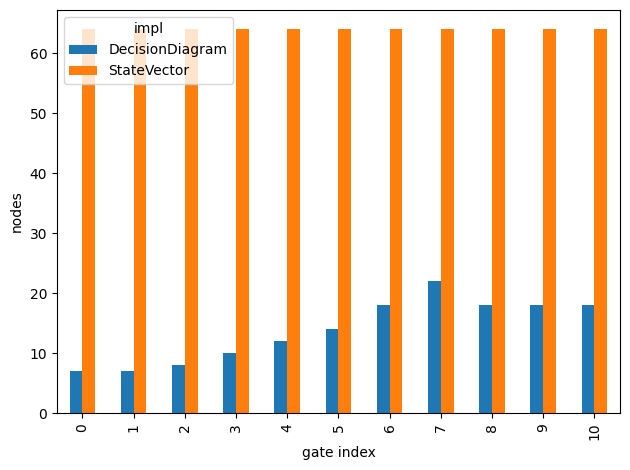

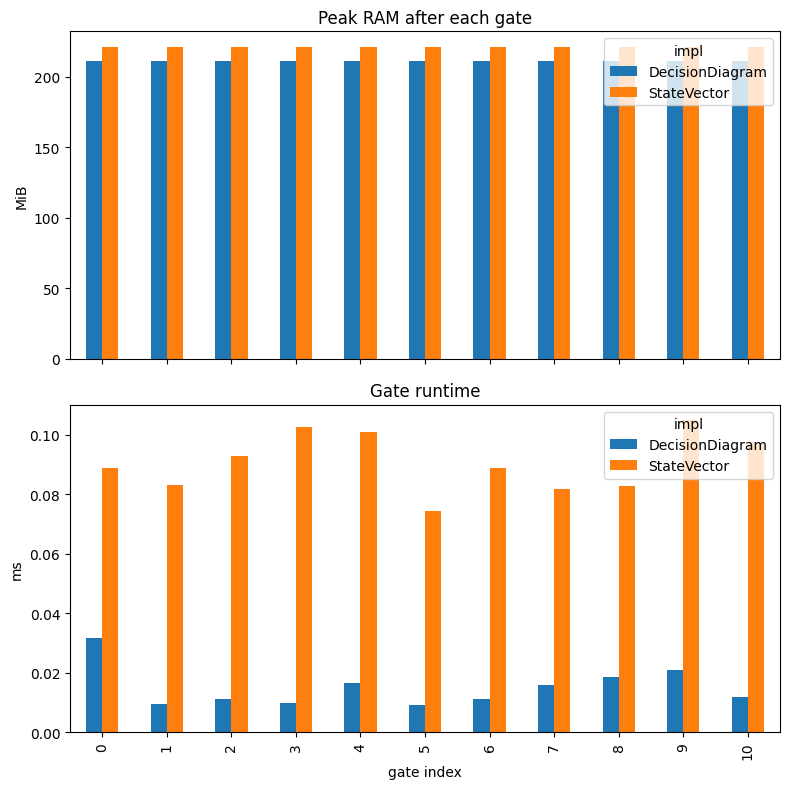

In [4]:
# pick file: uploaded version overrides dropdown

path = example_files[dropdown.value]

# simulate
stats, final_state = simulator.run_circuit(
    path,
    log_path='log',
)

# reference implementation
stats_sv, _ = comparison.run_statevector(path)
df_all = comparison.compare_logs(stats, stats_sv)
display(df_all)
comparison.plot_node_bars(df_all)

import matplotlib.pyplot as plt

# DataFrame erwartet Spalten: 'gate_idx', 'impl', 'ram_MB', 'runtime_ms'
pivot_ram   = df_all.pivot(index='gate_idx', columns='impl', values='ram_MB')
pivot_time  = df_all.pivot(index='gate_idx', columns='impl', values='runtime_ms')

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

pivot_ram.plot(kind='bar', ax=axes[0])
axes[0].set_title('Peak RAM after each gate')
axes[0].set_ylabel('MiB')

pivot_time.plot(kind='bar', ax=axes[1])
axes[1].set_title('Gate runtime')
axes[1].set_ylabel('ms')
axes[1].set_xlabel('gate index')

fig.tight_layout()
plt.show()


### 

### Student Playground
Feel free to modify the functions in `simulator.py` and observe the effects.